In [2]:
import pandas as pd

df = pd.read_csv("../creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Data Preparation

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


sampled_df, _ = train_test_split(df, 
                                test_size = 0.90, 
                                stratify = df['Class'], 
                                random_state = 42)

label_df = pd.DataFrame({"Class": sampled_df["Class"]})
sampled_df.drop(columns = ["Class", "Time"], inplace = True)

scaled_data = StandardScaler().fit_transform(sampled_df)
scaled_df = pd.DataFrame(scaled_data, columns = sampled_df.columns, index = sampled_df.index)

In [ ]:
import umap
import umap.plot

reducer = umap.UMAP()
embedding = reducer.fit(scaled_df)

## Generate Clusters

Key Parameters:

- **min_cluster_size**: The minimum number of points to form a dense cluster. Crucial for controlling noise and identifying meaningful clusters. Start with smaller values and experiment.

- **min_samples**: The number of points a neighborhood must contain for a point to be considered a core point. A larger value will result in more points being classified as noise. Usually smaller than min_cluster_size.

- **metric**: The distance metric to use. 'euclidean' (default), 'manhattan', 'cosine', etc. Consider based on your data's nature.

- **cluster_selection_method**: 'eom' (Excess of Mass) or 'leaf'. 'eom' is generally preferred as it's more robust.


[SK-Learn HDBScan Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

In [ ]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size = 75, 
                  min_samples = 2, 
                  metric = 'euclidean', 
                  cluster_selection_method = 'eom')

cluster_labels = hdbscan.fit_predict(scaled_data)
label_df["Cluster"] = cluster_labels

print(f"Number of clusters: {len(label_df['Cluster'].value_counts())}")

Number of clusters: 64


<Axes: >

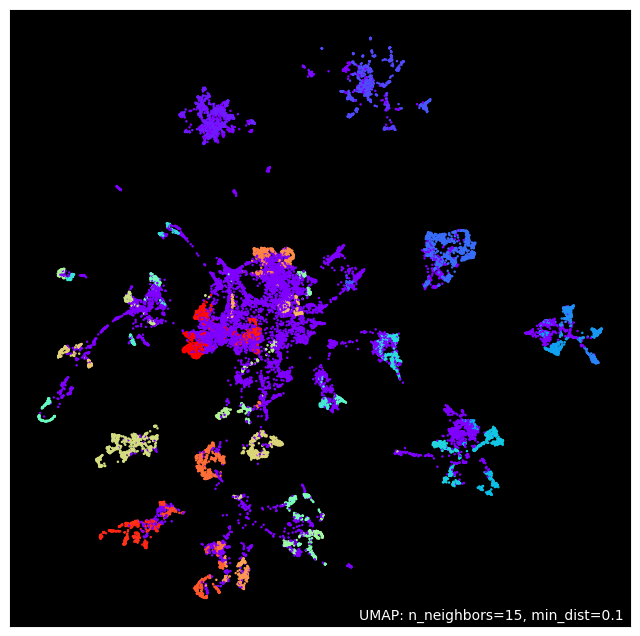

In [81]:
umap.plot.points(embedding, 
                 labels = label_df["Cluster"], 
                 theme = "fire", 
                 show_legend = False)

<Axes: >

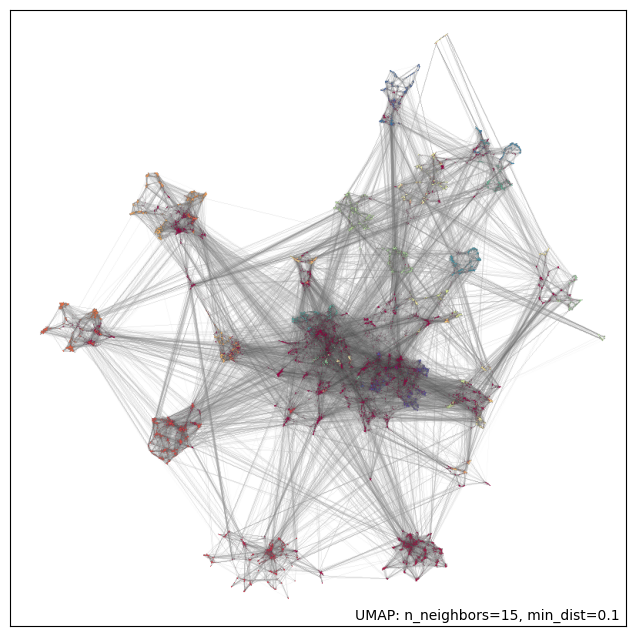

In [66]:
umap.plot.connectivity(embedding, labels = label_df["Cluster"], show_points=True)

In [77]:
import pandas as pd

distribution_table = (label_df.groupby('Cluster')
                     .agg({'Class': 'sum', 'Cluster': 'size'})
                     .rename(columns = {'Class': 'Fraud Count', 'Cluster': 'Total Transactions'})
                     .sort_values('Fraud Count', ascending = False)
                     [['Total Transactions', 'Fraud Count']])  # Select and reorder (Cluster is already the index)

print(distribution_table)

         Total Transactions  Fraud Count
Cluster                                 
-1                    12387           49
 0                      106            0
 1                     1338            0
 2                       89            0
 3                       90            0
...                     ...          ...
 58                     148            0
 59                     361            0
 60                     371            0
 61                     275            0
 62                     494            0

[64 rows x 2 columns]


## What if we then use an isolation_forest on just the noise? 

In [84]:
from sklearn.preprocessing import StandardScaler

## Isolate noise cluster into separate data frame
scaled_df["Cluster"] = label_df["Cluster"]
scaled_df["Class"] = label_df["Class"]
df_noise = scaled_df[scaled_df["Cluster"] == -1]

# Split the data into features 'X' and target 'y'
target_feature = "Class"
input_features = list(scaled_df.columns)
input_features.remove(target_feature)

X = scaled_df[input_features]
y = scaled_df[target_feature]

# # Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# # Apply data scaling 
# # Do I potentially need to go back to the original data at this point and re-scale it here to prevent data leakage? 
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [85]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination = 'auto', random_state = 42)
isolation_forest.fit(X_train)

# Predict outliers on the test set
outliers = isolation_forest.predict(X_test)
outliers = (outliers == -1).astype(int)

# Add predictions to the test set DataFrame
df_test = X_test.copy()
df_test['Outliers'] = outliers
df_test['Class'] = y_test

## Penalty Box

In [5]:
# import numpy as np

# hover_data = pd.DataFrame({'index':np.arange(len(label_df)),
#                            'label':label_df})

# hover_data['item'] = hover_data.label.map(
#     {
#         '0':'Legitimate',
#         '1':'Fraud'
#     }
# )

# umap.plot.output_notebook()

# p = umap.plot.interactive(embedding, labels = label_df, hover_data = hover_data, point_size = 2)
# umap.plot.show(p)

In [ ]:
# UMAP(a = None,
#      angular_rp_forest = False,
#      b = None,
#      force_approximation_algorithm = False, 
#      init = 'spectral', 
#      learning_rate = 1.0,
#      local_connectivity = 1.0, 
#      low_memory = False, 
#      metric='euclidean',
#      metric_kwds=None, 
#      min_dist=0.1, 
#      n_components=2, 
#      n_epochs=None,
#      n_neighbors=15, 
#      negative_sample_rate=5, 
#      output_metric='euclidean',
#      output_metric_kwds=None, 
#      random_state=42, 
#      repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, 
#      spread=1.0, 
#      target_metric='categorical',
#      target_metric_kwds=None, 
#      target_n_neighbors=-1, 
#      target_weight=0.5,
#      transform_queue_size=4.0, 
#      transform_seed=42, 
#      unique=False, 
#      verbose=False)

In [ ]:

import matplotlib.pyplot as plt 
import seaborn as sns

def umap_scatter_plot(scaled_df, df_class_column):

    if embedding.ndim == 2 and embedding.shape[1] >= 2:
        
        plt.figure(figsize=(12, 10))
        colours = [sns.color_palette()[x] for x in df_class_column]
                
        plt.scatter(
            x = embedding[:, 0],
            y = embedding[:, 1],
            c = colours,
            s = 1
            )

        plt.gca().set_aspect('equal', 'datalim')
        plt.title('UMAP projection of the fraud dataset', fontsize = 24)
        plt.show()
        
        
    else: 
        print("Error: `embedding` should be a 2-dimensional array with at least 2 columns.")
        
        
umap_scatter_plot(scaled_df, df["Class"])